In [4]:
# --------------------------------------------------------------
#   hhe_plaintext_accuracy.py
# --------------------------------------------------------------
"""
hhe_plaintext_accuracy
======================

Utility for loading the binary “0/1” output files produced by the
SIESTA_4percent and ESADA_4percent calculations and for evaluating the
HHE output as a binary classifier.

Features
--------
1. **Dataset loader** – ``load_dataset(base_dir)`` scans the two
   sub‑folders ``hhe_binaryoutput`` (predictions) and
   ``plaintext_binaryoutput`` (ground‑truth) that live under any supplied
   ``base_dir`` (e.g. ``SIESTA_4percent`` or ``ESADA_4percent``).  Each
   file is read line‑by‑line, the characters ``'0'`` or ``'1'`` are
   converted to the integers ``0`` and ``1`` and stored in a NumPy
   ``np.ndarray`` of dtype ``int``.  The dictionary key is the part of the
   filename that appears before the first underscore (e.g. ``p002801``).

2. **Accuracy comparison** – ``compare_accuracy`` treats the
   ``plain_dict`` as the true labels and ``hhe_dict`` as the predicted
   labels.  For every key that exists in both dictionaries it computes

   * per‑key accuracy  =  ``np.mean(pred == true)``  (as a percentage),
   * overall accuracy  =  weighted mean of the per‑key accuracies,
     weighted by the number of compared elements for each key.

   The implementation now uses the more readable ``len(array)`` instead
   of ``array.shape[0]``.

3. **Matplotlib visualisation** – ``plot_accuracy_reports`` draws a
   compact figure that summarises one or more accuracy reports (overall
   accuracy bar chart + per‑key accuracy histograms).

Typical usage
-------------
>>> from hhe_plaintext_accuracy import load_dataset, compare_accuracy, plot_accuracy_reports
>>> sie_hhe, sie_true = load_dataset('SIESTA_4percent')
>>> sie_report = compare_accuracy(sie_hhe, sie_true)
>>> esad_hhe, esad_true = load_dataset('ESADA_4percent')
>>> esad_report = compare_accuracy(esad_hhe, esad_true)
>>> plot_accuracy_reports({'SIESTA': sie_report, 'ESADA': esad_report})
"""

from __future__ import annotations

import os
import warnings
from pathlib import Path
from typing import Dict, Tuple, Mapping, List

import numpy as np

# ----------------------------------------------------------------------
# Optional Matplotlib import – the script works without it, but the
# visualisation functions will be disabled.
# ----------------------------------------------------------------------
try:
    import matplotlib.pyplot as plt  # type: ignore
    _HAS_MPL = True
except Exception:  # pragma: no cover
    _HAS_MPL = False


# ----------------------------------------------------------------------
# Helper functions# ----------------------------------------------------------------------
def _key_from_path(file_path: Path) -> str:
    """Return the dictionary key – the part of the filename before the first '_'."""
    return file_path.name.split('_', 1)[0]


def _read_file_as_int_array(file_path: Path) -> np.ndarray:
    """
    Read a file whose lines contain only ``'0'`` or ``'1'`` and return a
    NumPy 1‑D integer array (dtype ``int``).

    Raises
    ------
    ValueError
        If a line contains any character other than ``'0'`` or ``'1'``.
    """
    try:
        with file_path.open(encoding="utf-8") as f:
            int_values = []
            for line_no, line in enumerate(f, start=1):
                stripped = line.strip()
                if stripped not in {"0", "1"}:
                    raise ValueError(
                        f"Unexpected character in {file_path} on line {line_no}: "
                        f"{repr(stripped)} (expected '0' or '1')"
                    )
                int_values.append(int(stripped))
        return np.array(int_values, dtype=int)
    except Exception as exc:  # pragma: no cover
        raise IOError(f"Failed to read '{file_path}': {exc}") from exc


def _load_directory(
    root_dir: str | os.PathLike,
    pattern: str,
    *,
    allow_duplicates: bool = False,
) -> Dict[str, np.ndarray]:
    """
    Scan ``root_dir`` for files matching ``pattern`` and return a
    ``{key: np.ndarray}`` mapping.

    Parameters
    ----------
    root_dir : str or PathLike
        Directory that contains the files.
    pattern : str
        Glob pattern (e.g. ``"*_*_binaryoutput.txt"``).
    allow_duplicates : bool, optional
        If ``False`` (default) a ``ValueError`` is raised when two
        different files would generate the same key.

    Returns
    -------
    dict[str, np.ndarray]
        Mapping from the identifier (everything before the first underscore)
        to a NumPy integer array.
    """
    root = Path(root_dir)

    if not root.is_dir():
        raise NotADirectoryError(f"Directory does not exist: {root}")

    result: Dict[str, np.ndarray] = {}
    for fp in root.glob(pattern):
        if not fp.is_file():
            continue

        key = _key_from_path(fp)

        if not allow_duplicates and key in result:
            raise ValueError(
                f"Duplicate key '{key}' found for files '{result[key]}' and '{fp}'."
            )

        result[key] = _read_file_as_int_array(fp)

    return result


# ----------------------------------------------------------------------
# Public API – loading a *single* dataset
# ----------------------------------------------------------------------
def load_dataset(
    base_dir: str | os.PathLike = "SIESTA_4percent",
) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    """
    Load the two groups of files that live under ``base_dir`` and return
    the predictions (HHE) and the ground‑truth (plaintext) dictionaries.

    Expected layout::

        <base_dir>/hhe_binaryoutput/*_hhe_binaryoutput.txt
        <base_dir>/plaintext_binaryoutput/*_binaryoutput.txt

    Parameters
    ----------
    base_dir : str or PathLike
        Root directory that contains the two sub‑folders described above
        (e.g. ``SIESTA_4percent`` or ``ESADA_4percent``).

    Returns
    -------
    tuple(dict, dict)
        ``(hhe_dict, plain_dict)`` – each mapping ``key → np.ndarray(int)``.
    """
    hhe_pattern = "*_hhe_binaryoutput.txt"
    plain_pattern = "*_binaryoutput.txt"

    hhe_dir = Path(base_dir) / "hhe_binaryoutput"
    plain_dir = Path(base_dir) / "plaintext_binaryoutput"

    hhe_dict = _load_directory(hhe_dir, hhe_pattern)
    plain_dict = _load_directory(plain_dir, plain_pattern)

    return hhe_dict, plain_dict


# ----------------------------------------------------------------------
# Human‑friendly accuracy comparison (uses len() instead of shape[0])
# ----------------------------------------------------------------------
def compare_accuracy(
    hhe_dict: Dict[str, np.ndarray],
    plain_dict: Dict[str, np.ndarray],
) -> Dict[str, object]:
    """
    Compute the binary‑classification accuracy of the HHE predictions
    (``hhe_dict``) against the true values (``plain_dict``).

    The function works key‑by‑key:

    * Only keys that appear **in both** dictionaries are compared.
    * If the two arrays for a key have different lengths, the longer one is
      truncated to the length of the shorter one and a warning is emitted.
    * For each common key the per‑key accuracy is ``np.mean(pred == true)``.
    * The overall accuracy is a **weighted mean** of the per‑key accuracies,
      where the weight is the number of compared elements for that key.

    Returns
    -------
    dict
        ``{
            "per_key":   {key: accuracy_percent},
            "overall":   overall_accuracy_percent,
            "missing":   {"only_in_hhe": [...], "only_in_plain": [...]}
        }``

    Percentages are rounded to two decimal places.
    """
    per_key: Dict[str, float] = {}
    total_correct = 0
    total_compared = 0

    # Keys present in both dictionaries
    common_keys = set(hhe_dict).intersection(plain_dict)

    for key in common_keys:
        pred = hhe_dict[key]          # prediction array (0/1)
        true = plain_dict[key]        # ground‑truth array (0/1)

        # ------------------------------------------------------------------
        # Ensure the two arrays have the same length.
        # ------------------------------------------------------------------
        if len(pred) != len(true):
            min_len = min(len(pred), len(true))
            warnings.warn(
                f"Length mismatch for key '{key}': "
                f"HHE has {len(pred)} entries, plain has {len(true)} entries. "
                f"Truncating to {min_len} entries for comparison.",
                RuntimeWarning,
                stacklevel=2,
            )
            pred = pred[:min_len]
            true = true[:min_len]

        # ------------------------------------------------------------------
        # Element‑wise equality → number of correct predictions
        # ------------------------------------------------------------------
        correct = np.sum(pred == true)   # how many bits match
        n = len(pred)                    # total number of bits compared

        # ------------------------------------------------------------------
        # Per‑key accuracy as a percentage (rounded to 2 dp)
        # ------------------------------------------------------------------
        per_key[key] = round((correct / n) * 100, 2)

        # ------------------------------------------------------------------
        # Accumulate for the overall (weighted) accuracy
        # ------------------------------------------------------------------
        total_correct += correct
        total_compared += n

    overall = round((total_correct / total_compared) * 100, 2) if total_compared else 0.0

    missing = {
        "only_in_hhe": sorted(set(hhe_dict) - set(plain_dict)),
        "only_in_plain": sorted(set(plain_dict) - set(hhe_dict)),
    }

    return {"per_key": per_key, "overall": overall, "missing": missing}


# ----------------------------------------------------------------------
# Matplotlib visualisation
# ----------------------------------------------------------------------
def plot_accuracy_reports(
    reports: Mapping[str, Dict[str, object]],
    *,
    figsize: Tuple[float, float] = (10, 6),
    bins: int = 20,
    save_path: str | None = None,
) -> None:
    """
    Draw a compact figure that summarises one or more accuracy reports.

    The figure contains two sub‑plots:

    1. **Bar chart** – overall accuracy for each dataset.
    2. **Histogram** – distribution of per‑key accuracies for each dataset
       (semi‑transparent bars so they can be over‑laid).

    Parameters
    ----------
    reports : mapping
        ``{dataset_name: report_dict}`` where each ``report_dict`` is the
        output of :func:`compare_accuracy`.
    figsize : tuple, optional
        Size of the Matplotlib figure (default ``(10, 6)``).
    bins : int, optional
        Number of histogram bins for the per‑key accuracies (default 20).
    save_path : str or None, optional
        If provided, the figure is saved to this path (e.g. ``"accuracy.png"``)
        instead of (or in addition to) being shown on screen.

    Raises
    ------
    RuntimeError
        If Matplotlib is not available.
    """
    if not _HAS_MPL:  # pragma: no cover
        raise RuntimeError(
            "Matplotlib is required for plotting but could not be imported."
        )

    # ------------------------------------------------------------------
    # 1️⃣ Prepare data
    # ------------------------------------------------------------------
    dataset_names: List[str] = list(reports.keys())
    overall_vals: List[float] = [reports[name]["overall"] for name in dataset_names]

    per_key_arrays: List[np.ndarray] = [
        np.array(list(reports[name]["per_key"].values())) for name in dataset_names
    ]

    # ------------------------------------------------------------------
    # 2️⃣ Create figure
    # ------------------------------------------------------------------
    fig, (ax_bar, ax_hist) = plt.subplots(
        1,
        2,
        figsize=figsize,
        gridspec_kw={"width_ratios": [1, 1.5]},
    )

    # ---- Bar chart (overall accuracy) ---------------------------------
    bars = ax_bar.bar(dataset_names, overall_vals, color="steelblue")
    ax_bar.set_ylim(0, 100)
    ax_bar.set_ylabel("Overall accuracy (%)")
    ax_bar.set_title("Overall accuracy per dataset")
    for bar, val in zip(bars, overall_vals):
        ax_bar.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{val:.2f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # ---- Histogram (per‑key accuracy distribution) --------------------
    colors = plt.cm.tab10.colors
    for idx, (name, arr) in enumerate(zip(dataset_names, per_key_arrays)):
        ax_hist.hist(
            arr,
            bins=bins,
            range=(0, 100),
            alpha=0.5,
            label=name,
            color=colors[idx % len(colors)],
            edgecolor="black",
        )
    ax_hist.set_xlabel("Per‑key accuracy (%)")
    ax_hist.set_ylabel("Number of files")
    ax_hist.set_title("Distribution of per‑file accuracies")
    ax_hist.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Plot saved to {save_path}")
    else:
        plt.show()


=== SIESTA dataset ===
✅ Loaded 399 HHE files.
✅ Loaded 399 plaintext files.

🔎 Overall accuracy for SIESTA: 82.29%
🔎 Number of keys compared: 399

🔻 10 most inaccurate files:
    c001101 → 14.29%
    c003802 → 22.22%
    c002501 → 23.53%
    c002202 → 30.43%
    c003002 → 31.25%
    c001202 → 31.58%
    sa02102 → 31.82%
    m003902 → 34.62%
    c002502 → 35.00%
    c002201 → 37.50%

🔺 10 most accurate files:
    p000601 → 100.00%
    na01102 → 100.00%
    n000701 → 100.00%
    p000302 → 100.00%
    na01701 → 100.00%
    p003402 → 100.00%
    n003602 → 100.00%
    p000401 → 100.00%
    na01101 → 100.00%
    p000702 → 100.00%

=== ESADA dataset ===
✅ Loaded 423 HHE files.
✅ Loaded 426 plaintext files.

🔎 Overall accuracy for ESADA: 81.57%
🔎 Number of keys compared: 423

🔻 10 most inaccurate files:
        398 →  0.00%
        303 → 28.57%
        369 → 29.41%
        153 → 33.33%
         76 → 34.33%
        238 → 34.62%
        136 → 35.29%
        324 → 38.10%
        407 → 38.46%
  

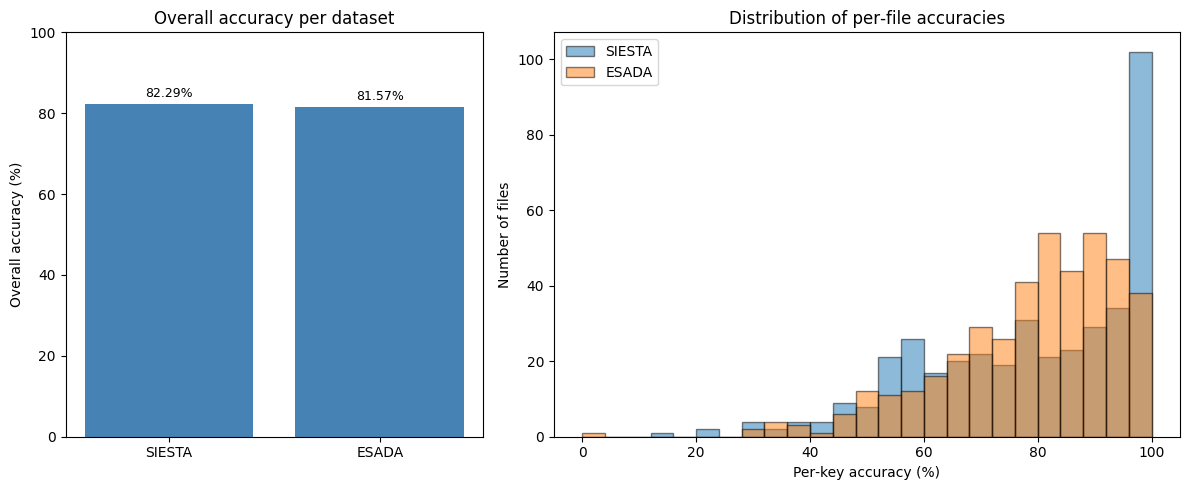

In [5]:
# ----------------------------------------------------------------------
# Demo / CLI – runs when the file is executed directly
# ----------------------------------------------------------------------
if __name__ == "__main__":
    try:
        # ------------------------------------------------------------------
        # Load both datasets
        # ------------------------------------------------------------------
        datasets = {
            "SIESTA": load_dataset("SIESTA_4percent"),
            "ESADA": load_dataset("ESADA_4percent"),
        }

        # ------------------------------------------------------------------
        # Compute reports
        # ------------------------------------------------------------------
        reports: Dict[str, Dict[str, object]] = {}
        for name, (hhe_dict, plain_dict) in datasets.items():
            print(f"\n=== {name} dataset ===")
            print(f"✅ Loaded {len(hhe_dict)} HHE files.")
            print(f"✅ Loaded {len(plain_dict)} plaintext files.\n")

            report = compare_accuracy(hhe_dict, plain_dict)
            reports[name] = report

            # ---- Textual summary -------------------------------------------------
            print(f"🔎 Overall accuracy for {name}: {report['overall']:.2f}%")
            print(f"🔎 Number of keys compared: {len(report['per_key'])}")

            # 10 worst (lowest‑accuracy) keys
            worst = sorted(report["per_key"].items(), key=lambda kv: kv[1])[:10]
            print("\n🔻 10 most inaccurate files:")
            for k, acc in worst:
                print(f"   {k:>8} → {acc:5.2f}%")

            # 10 best (highest‑accuracy) keys
            best = sorted(report["per_key"].items(), key=lambda kv: kv[1], reverse=True)[:10]
            print("\n🔺 10 most accurate files:")
            for k, acc in best:
                print(f"   {k:>8} → {acc:5.2f}%")

            # Missing‑key summary
            if report["missing"]["only_in_hhe"] or report["missing"]["only_in_plain"]:
                print("\n⚠️  Missing‑key summary:")
                if report["missing"]["only_in_hhe"]:
                    print(
                        f"   Present only in HHE ({len(report['missing']['only_in_hhe'])}):",
                        ", ".join(report["missing"]["only_in_hhe"][:5]),
                        "...",
                    )
                if report["missing"]["only_in_plain"]:
                    print(
                        f"   Present only in plain ({len(report['missing']['only_in_plain'])}):",
                        ", ".join(report["missing"]["only_in_plain"][:5]),
                        "...",
                    )

        # ------------------------------------------------------------------
        # Plot the summary figure (if Matplotlib is available)
        # ------------------------------------------------------------------
        if _HAS_MPL:
            plot_accuracy_reports(
                reports,
                figsize=(12, 5),
                bins=25,
                # Uncomment the next line if you want to save the figure instead of showing it:
                # save_path="accuracy_summary.png"
            )
        else:
            print("\n⚠️  Matplotlib not installed – skipping the plot.")
    except Exception as exc:  # pragma: no cover
        print(f"❌  Error while loading/comparing files: {exc}")